In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [4]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [7]:
searches = 'Aphids','Army worm','Bacterial Blight','Healthy','Powdery Mildew','Target spot'
path = Path('Cotton plant')
from time import sleep

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

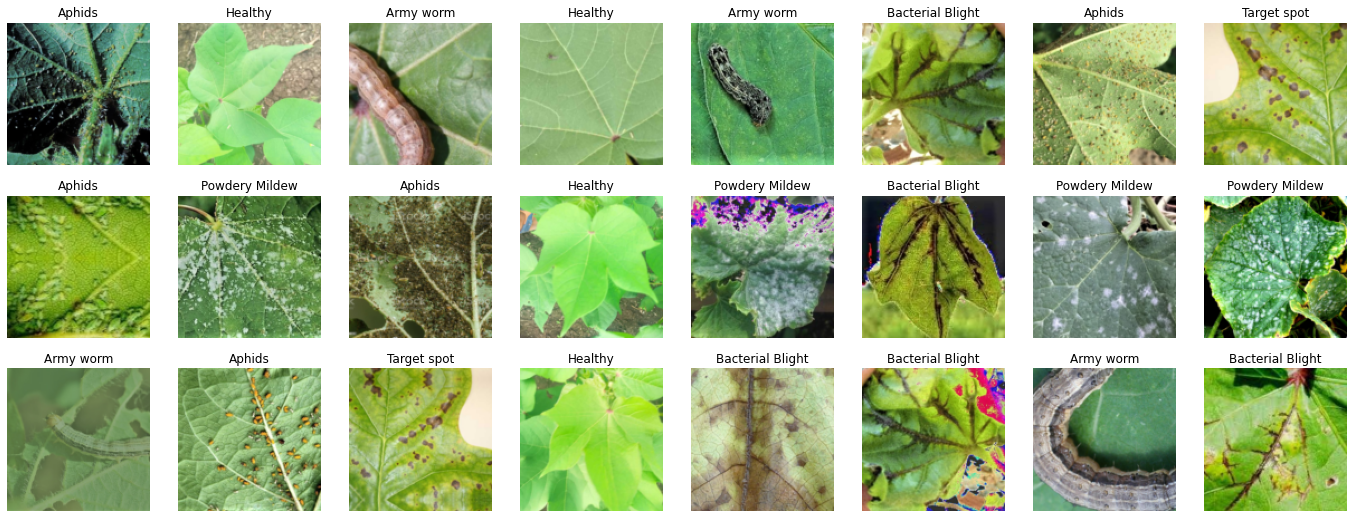

In [23]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

dls = plants.dataloaders(path)

dls.show_batch(max_n=24 , nrows=3)

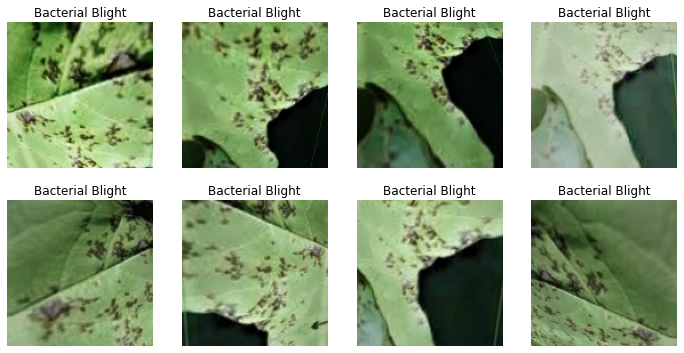

In [24]:
plants = plants.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [25]:
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.393840,0.355597,0.112500,01:38


epoch,train_loss,valid_loss,error_rate,time
0,0.322532,0.122594,0.031250,02:03
1,0.197387,0.080753,0.025000,02:02
2,0.132208,0.068715,0.020833,02:13
3,0.086851,0.060152,0.020833,02:12


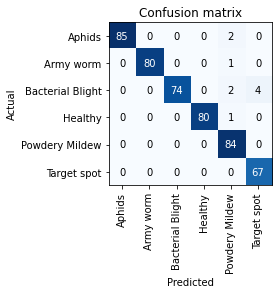

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()